## Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import copy

In [2]:
df = pd.read_csv("subscribers.csv")

In [3]:
column_list = ['package_type','preferred_genre','intended_use','weekly_consumption_hour','age','male_TF']
data1 = df[column_list]

In [4]:
data1 = data1.dropna()

In [5]:
data1.drop(data1[data1.age > 80].index, inplace=True)
data1.drop(data1[data1.age < 15].index, inplace=True)

In [6]:
data2 = pd.get_dummies(data = data1, columns=['package_type', 'preferred_genre', 'intended_use','male_TF'])
print(data2.columns)
print(data2.shape)

Index(['weekly_consumption_hour', 'age', 'package_type_base',
       'package_type_economy', 'package_type_enhanced',
       'preferred_genre_comedy', 'preferred_genre_drama',
       'preferred_genre_international', 'preferred_genre_other',
       'preferred_genre_regional', 'intended_use_access to exclusive content',
       'intended_use_education', 'intended_use_expand international access',
       'intended_use_expand regional access', 'intended_use_other',
       'intended_use_replace OTT', 'intended_use_supplement OTT',
       'male_TF_False', 'male_TF_True'],
      dtype='object')
(153860, 19)


In [7]:
data_cleaned_dummified = data2.copy()
data_cleaned_dummified.to_csv('subscribers_cleaned_dummified.csv', index=False)

## 1. Customer Segmentation

In [8]:
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import datetime

In [10]:
pd.set_option('display.max_columns', 25)

In [11]:
def run_kmeans(n_clusters_f, init_f, df_f):
    k_means_model_f = KMeans(n_clusters=n_clusters_f, init=init_f).fit_predict(df_f)
    k_means_model_f = pd.DataFrame(k_means_model_f)
    k_means_model_f['123'] = df_f.index
    k_means_model_f = k_means_model_f.set_index('123', drop=True, append=False, inplace=False, verify_integrity=False)
    k_means_model_f.columns = ['predict_cluster_kmeans']

    df_f = pd.concat([df_f, k_means_model_f], axis=1, join='outer')

    k_means_model_f_summary = df_f.groupby('predict_cluster_kmeans').agg(attribute_summary_method_dict)
    return k_means_model_f, k_means_model_f_summary

In [12]:
df_cluster = pd.read_csv('subscribers_cleaned_dummified.csv')

In [13]:
n_clusters = 3
init_point_selection_method = 'k-means++'

In [14]:
df_cluster_train, df_cluster_test, _, _, = train_test_split(df_cluster, [1]*df_cluster.shape[0], test_size=0.33) 

In [15]:
attribute_summary_method_dict = {'weekly_consumption_hour': np.mean, 'age': np.mean,'package_type_base':sum,'package_type_economy':sum,'package_type_enhanced':sum,'preferred_genre_comedy':sum,'preferred_genre_drama':sum,'preferred_genre_international':sum,'preferred_genre_other':sum,'preferred_genre_regional':sum,'intended_use_access to exclusive content':sum,'intended_use_education':sum,'intended_use_expand international access':sum,'intended_use_expand regional access':sum,'intended_use_other':sum,'intended_use_replace OTT':sum,'intended_use_supplement OTT':sum,'male_TF_False':sum,'male_TF_True':sum}
col_output_order = ['weekly_consumption_hour', 'age', 'package_type_base',
       'package_type_economy', 'package_type_enhanced',
       'preferred_genre_comedy', 'preferred_genre_drama',
       'preferred_genre_international', 'preferred_genre_other',
       'preferred_genre_regional', 'intended_use_access to exclusive content',
       'intended_use_education', 'intended_use_expand international access',
       'intended_use_expand regional access', 'intended_use_other',
       'intended_use_replace OTT', 'intended_use_supplement OTT',
       'male_TF_False', 'male_TF_True'] 

In [16]:
train_model, train_model_summary = run_kmeans(n_clusters, init_point_selection_method, df_cluster_train.reindex())

In [17]:
test_model, test_model_summary = run_kmeans(n_clusters, init_point_selection_method, df_cluster_test.reindex())

In [18]:
model, model_summary = run_kmeans(n_clusters, init_point_selection_method, df_cluster)

In [19]:
ks = range(1, 10)
inertias = []

In [20]:
for k in ks:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(df_cluster)
    inertias.append(model.inertia_)

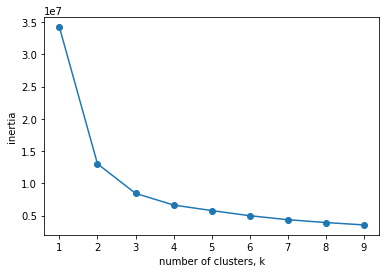

In [21]:
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [22]:
model = KMeans(n_clusters=3, n_init=10)
model.fit(df_cluster)
output = pd.DataFrame(model.cluster_centers_)
output.columns = df_cluster.columns
output.to_csv('Kmeans_output.csv')